In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import config
from tyssue.draw import sheet_view
import pandas as pd
import numpy as np
import random
from tyssue.core import objects

In [2]:
from tyssue.core.sheet import Sheet
from tyssue.geometry.sheet_geometry import SheetGeometry

sheet_3d = Sheet.planar_sheet_3d('sheet', nx=20, ny=20, 
                                 distx=1, disty=1)
shifts = [-1]

for index, vertex in sheet_3d.vert_df.iterrows():
    sheet_3d.vert_df.at[index, 'basal_shift'] = random.choice(shifts)

SheetGeometry.update_all(sheet_3d)
sheet_3d.sanitize()
#sheet_3d.vert_df['basal_shift'] = -1

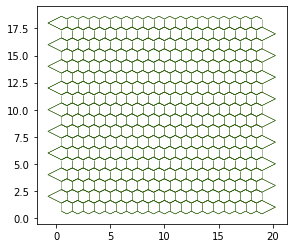

In [16]:
fig, ax = sheet_view(sheet_3d, ['x', 'y'], mode='quick')

In [4]:
from tyssue import utils

Calculating the sub areas i.e. $\bf{v}_{i} \wedge \bf{v}_{i+1}$. As written in Shvartsman at al (2015), $\sum_{edges} \bf{v}_{i} \times \bf{v}_{i+1}$ gives the area of the polygon. Where $i$ and $i+1$ indicate adjacent vertices in the clockwise sense. 




> I think this defintion is equivalent to the computation already in place:

$$
\begin{eqnarray}
\sum (v_\alpha - v_i) \times (v_j - v_i) &=& \sum \left(v_\alpha \times (v_j - v_i) + v_i \times v_j\right)\\
    &=& v_\alpha \times \sum(v_i - v_j) + \sum(v_i \times v_j)\\
    &=& \sum(v_i \times v_j) \quad \mbox{because the polygon is closed} \quad \sum(v_i -v_j) = 0\\
\end{eqnarray}
$$

`s_area_x/y/z` is x/y/z component of Area vector calculated as defined by Shvartsman

# Shvartsman Definition for Areas
We must integrate the new difinition for the areas and `sub_area`s to calculate the bending energy of the entire network and the gradients at each vertex.

In [5]:
sheet_3d.face_df['s_area_z'] = sheet_3d.sum_face(sheet_3d.edge_df['nz'])
sheet_3d.face_df['s_area_x'] = sheet_3d.sum_face(sheet_3d.edge_df['nx'])
sheet_3d.face_df['s_area_y'] = sheet_3d.sum_face(sheet_3d.edge_df['ny'])

list_a=sheet_3d.face_df['s_area_y']
list_b=sheet_3d.face_df['s_area_x']
list_c=sheet_3d.face_df['s_area_z']

#area=np.linalg.norm(areas)


In [6]:
# Unfortunately you can't assign values to multiple new columns
# in pandas

area_vector = sheet_3d.sum_face(sheet_3d.edge_df[sheet_3d.ncoords])
for nc in sheet_3d.ncoords:
    sheet_3d.face_df[nc] = area_vector[nc]

As pointed earlier, both definitions of the area are equivalent, so you could rely on the one computed in `SheetGeometry`

In [7]:
# s_area_coord = []
# for index, face in sheet_3d.face_df.iterrows():
#    area = [sheet_3d.face_df.at[index, 's_area_x'], sheet_3d.face_df.at[index, 's_area_y'], sheet_3d.face_df.at[index, 's_area_z']]
#    s_area_coord.append(area)
    
# I don't understand why you do that, but it is extremly inefficient
# you can have exactly the same result
# with 

s_area = np.linalg.norm(sheet_3d.face_df[['s_area_x',
                                          's_area_y',
                                          's_area_z']], axis=1)
sheet_3d.face_df['s_area_norm'] = s_area

sheet_3d.face_df.head()

,y,is_alive,perimeter,area,x,num_sides,z,height,rho,vol,s_area_z,s_area_x,s_area_y,nx,ny,nz,s_area_norm
face,,,,,,,,,,,,,,,,,
0,1.0,1,3.736068,1.0,1.0,6,0,1.0,0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0
1,1.0,1,3.736068,1.0,2.0,6,0,1.0,0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0
2,1.0,1,3.736068,1.0,3.0,6,0,1.0,0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0
3,1.0,1,3.736068,1.0,4.0,6,0,1.0,0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0
4,1.0,1,3.736068,1.0,5.0,6,0,1.0,0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0


# Calculation of Bending Energy

In [8]:
scoords = ['s_area_'+c for c in 'xyz']
sheet_3d.get_opposite()

for c in scoords:
    sheet_3d.edge_df[c] = sheet_3d.upcast_face(sheet_3d.face_df[c])
sheet_3d.edge_df['s_area_norm'] = sheet_3d.upcast_face(sheet_3d.face_df['s_area_norm'])

na_coords = ['N'+c for c in 'xyz'] # normalized area vector
for c in sheet_3d.coords:
    sheet_3d.edge_df['N'+c] = sheet_3d.edge_df['n'+c] / sheet_3d.edge_df['s_area_norm']

# Index of the edges with an opposite:
dble_edges = sheet_3d.edge_df[sheet_3d.edge_df['opposite'] >= 0].index
# Index over the opposite edges:
oppo_edges = sheet_3d.edge_df.loc[dble_edges, 'opposite'].values

neighbour_dot = pd.Series(np.ones(sheet_3d.Ne),
                          index=sheet_3d.edge_df.index) # 1 for single edges
neighbour_dot.loc[dble_edges] = (
    sheet_3d.edge_df.loc[dble_edges, na_coords].values * 
    sheet_3d.edge_df.loc[oppo_edges, na_coords].values).sum(axis=1)

sheet_3d.edge_df['neighbour_dot'] = neighbour_dot

For reference, here is your implementation of the above:
```python
sheet_3d.edge_df['opposite'] = objects.get_opposite(sheet_3d.edge_df)
neighbour_dot =[]
for index, edge in sheet_3d.edge_df.iterrows():
    
    if sheet_3d.edge_df.at[index, 'opposite'] == -1:
        
        N_ij = 1
        neighbour_dot.append(N_ij)
        
    else:
        
        edge_opp = sheet_3d.edge_df.at[index, 'opposite']
        
        face_i = sheet_3d.edge_df.at[index, 'face']
        face_j = sheet_3d.edge_df.at[edge_opp, 'face']
        
        norm_i = (sheet_3d.face_df.at[face_i, 's_area_norm'])
        norm_j = (sheet_3d.face_df.at[face_j, 's_area_norm'])
        
        Nx_i = (sheet_3d.face_df.at[face_i, 's_area_x']) / norm_i 
        Nx_j = (sheet_3d.face_df.at[face_j, 's_area_x']) / norm_j
        Ny_i = (sheet_3d.face_df.at[face_i, 's_area_y']) / norm_i
        Ny_j = (sheet_3d.face_df.at[face_j, 's_area_y']) / norm_j
        Nz_i = (sheet_3d.face_df.at[face_i, 's_area_z']) / norm_i
        Nz_j = (sheet_3d.face_df.at[face_j, 's_area_z']) / norm_j
        
        N_ij = ((Nx_i * Nx_j) + (Ny_i * Ny_j) + (Nz_i * Nz_j))
        
        neighbour_dot.append(N_ij)
        
sheet_3d.edge_df['neighbour_dot'] = neighbour_dot
```

In python, it is preferable to avoid explicit loops over the lines of a DataFrame


# Expression for Gradient


For gradient of the Bending Energy, we will have to calculate: $$ \nabla E_{bend} =  \frac {{\partial \, (\bf{N}_i \cdot \bf{N} _j) }} { \partial \, \bf{r}_k} $$

Where, $i$ and $j$ are indices of two faces on either side an edge and $\bf{r}_k$ is the position vector of the $k^{th}$ vertex. If expanded, it can be written as: 

$$ \frac {\partial \, (\bf{N}_i \cdot \bf{N} _j) } { \partial \, \bf{r}_k} = \bf{N}_i \cdot \frac {\partial \, ( \bf{N} _j)} { \partial \, \bf{r}_k} + \bf{N}_j \cdot \frac {{\partial \, ( \bf{N} _i) }} { \partial \, \bf{r}_k}$$ 

Therefore, alternatively, one could calculate the gradients for each vertex by calculating the gradients for the vertices by looping over each face. Therefore, we can now calculate: $$\bf{N}_j \cdot \frac {\partial ( \bf{N} _i)} { \partial \bf{r}_k}$$ and the other term would be automatically added to the vertex gradient when it comes up while looping over the $j^{th}$ cell. Now, $$ {\bf{N}_i} = \frac {{\bf{A}_i}} {{A}_i}$$ 

Therefore, 
$$\frac {{\partial \, {\bf{N} _i} }} { \partial \bf{r}_k} = \frac {{\partial \, {\bf{A}_i} / A_i }} { \partial \, \bf{r}_k}$$

$$\frac {{\partial \,{\bf{A}_i} / {A}_i }} { \partial \, \bf{r}_k} =  {\bf {A_i}} \otimes \frac {{\partial \,  A_i ^{-1} }} { \partial \, \bf{r}_k} + \frac{1} {{A}_i} \frac {{\partial \, \bf{A}_i }} { \partial \, \bf{r}_k} $$

Now the first term on the right hand side of the equation can written as: $${\bf {A_i}} \otimes \frac {{\partial \,  A_i ^{-1} }} { \partial \, \bf{r}_k} = \frac {\bf - {A}_i} {2 {A_i}^3} \otimes \frac {{\partial \,  ({\bf{A}_i} \cdot {\bf{A}_i}) }} { \partial \, \bf{r}_k} = - \frac {1}{{A_i}^3} (\bf{A}_i \otimes \bf{A}_i) \frac {\partial \, \bf{A}_i} {\partial \, \bf{r}_k} $$

$$\frac {{\partial \,{\bf{A}_i} / {A}_i }} { \partial \, \bf{r}_k} = \frac {1}{A_i} \Big(\mathbb{1}-\frac{1}{A_i^2} {\bf{A}_i}\otimes{\bf{A}_i}\Big)\frac {{\partial \,{\bf{A}_i}}} { \partial \, \bf{r}_k}$$

For calculating the contribution to the energy gradient of the $k^{th}$ vertex from cell $i$, 

$$ \nabla _{k} E_{bend} = \sum _{i}\sum _{j \, \epsilon \, ngb} \Bigg( \frac {1}{A_i} \Big(\mathbb{1}-\frac{1}{A_i^2} {\bf{A}_i}\otimes{\bf{A}_i}\Big)\frac {{\partial \,{\bf{A}_i}}} { \partial \, \bf{r}_k}\Bigg) \cdot {\bf{N}_j} $$
Where $i$ represents all the cells connected to the $k^{th}$ vertex and $j$ runs over all the elements of $ngb$ which is the set of all the cells in the neighborhood of cell $i$.

Now,  we have defined area of the cell $i$ as: 

$${\bf{A}_i}= (\bf{v}_{1} \times \bf{v}_{2}) + ({v}_{2} \times \bf{v}_{3}) + \dots + ({v}_{n} \times \bf{v}_{1})$$

Where, ${\bf{v}_{1}}, {\bf{v}_{2}}, {\bf{v}_{3}}, \dots$ are coordinates of the vertices. Therefore, the x component of the area vector of $i^{th}$ cell given as given as: 

$$A_{x}^{i}=\sum_{<k,k+1>}\big(v_{y}^{k}\cdot v_{z}^{k+1}-v_{y}^{k+1}\cdot v_{z}^{k}\big)$$

Where $<k,k+1>$ denote the summation over all pairs of adjecent vertices. Similarly, we have: 

$$A_{y}^{i}=\sum_{<k,k+1>}\big(v_{x}^{k+1}\cdot v_{z}^{k}-v_{x}^{k}\cdot v_{z}^{k+1}\big)$$

$$A_{z}^{i}=\sum_{<k,k+1>}\big(v_{x}^{k}\cdot v_{y}^{k+1}-v_{x}^{k+1}\cdot v_{y}^{k}\big)$$

now, the tensor $ ({\partial \, {\bf{A}_i}}) / ({\partial \, {\bf{v}_k}})$, (where the coordinates of the $k^{th}$ vertex has been written as ${\bf{v}_k}$ instead of ${\bf{r}_k}$ before) has nine components. 
On looking at the expressions for $A_{x}^{i}$, $A_{y}^{i}$, $A_{z}^{i}$,  we notice that the components:
$$\frac {\partial \, {A_{s}^{i}}}  {\partial \, {v_{r}^{k}}} = 0\quad If \quad s=r $$ This means that the tensor $({\partial \, {\bf{A}_i}}) / ({\partial \, {\bf{v}_k}})$ will have only six nonzero components. These are given by:

$$\frac {\partial \, {A_{s}^{i}}}  {\partial \, {v_{r}^{k}}} = \frac {1} {\partial \, {v_{r}^{k}}} \bigg( \sum_{<k,k+1>}\sum_r \sum_t \varepsilon_{srt} (v_{r}^{k}\cdot v_{t}^{k+1})\bigg) = \varepsilon_{srt}\big(v_{t}^{k+1} - v_{t}^{k-1}\big)$$

This finally, this shows that $ ({\partial \, {\bf{A}_i}}) / ({\partial \, {\bf{v}_k}})$ is a traceless, antisymmetric tensor. 

$$\implies \nabla _{k} E_{bend} = B \sum _{i}\sum _{j \, \epsilon \, ngb} \Bigg( \frac {1}{A_i} \Big(\mathbb{1}-\frac{1}{A_i^2} {\bf{A}_i}\otimes{\bf{A}_i}\Big)\frac {{\partial \,{\bf{A}_i}}} { \partial \, \bf{r}_k}\Bigg) \cdot {\bf{N}_j}$$




# Calculation of Gradient

Here I'm using numpy's Einstein summation tool to perform the dyadic product and other multiplications.

Although it's a bit hard to understand - at least I found it so ;-) - it is very efficient.
Appart from the doc, I found a good set of examples here: http://ajcr.net/Basic-guide-to-einsum/

Here is a simple example:

```python
a = np.arange(12).reshape((4, 3))
np.einsum('...i, ...j', a, a)
```

The general strategy is to **compute everything at the edge level** and sum only in the end.



In [10]:
A_dyad_A = np.einsum('...i, ...j',
                     sheet_3d.edge_df[scoords].values,
                     sheet_3d.edge_df[scoords].values,
                     optimize=True)

A_1 = (1 / sheet_3d.edge_df['s_area_norm']).values
A_2 = A_1**2

I = np.tile(np.identity(3), sheet_3d.Ne).reshape(sheet_3d.Ne, 3, 3)

AA = (I - A_dyad_A * A_2[:, np.newaxis, np.newaxis])

# We have one 3 by 3 tensor per edge
print(AA.shape)

(2034, 3, 3)


I'm not sure I understand completely your computation of $\partial \mathbf{A}_i/\partial r_k$ -- You can refer to [the implementation for the original area](https://github.com/DamCB/tyssue/blob/master/tyssue/dynamics/sheet_gradients.py#L60).


The method I use to compute $\partial A_i/\partial r_k$ is to have to terms per vertex per cell, one for the edge of which the vertex is a source, one for the edge for which the vertex is a target. So your term in $k+1$ would go to the `grad_a_srce`, and the term in $k-1$ in `grad_a_trgt`.

If I understand correctly:


In [11]:
import itertools


srce_pos = sheet_3d.upcast_srce(sheet_3d.vert_df[sheet_3d.coords]).values
trgt_pos = sheet_3d.upcast_trgt(sheet_3d.vert_df[sheet_3d.coords]).values
anti_sym = np.array([[ 0,  1, 1],
                     [-1,  0, 1],
                     [-1, -1, 0]])

dA_srce = np.zeros((sheet_3d.Ne, 3, 3))
dA_trgt = np.zeros((sheet_3d.Ne, 3, 3))

for (i, j, k) in itertools.permutations([0, 1, 2]):
    dA_srce[:, i, j] = srce_pos[:, k] * anti_sym[i, j]
    dA_trgt[:, i, j] = trgt_pos[:, k] * anti_sym[i, j]



Computation of the whole terms

In [12]:
AdA_srce = np.einsum('...ij, ...jk', AA, dA_srce)
AdA_trgt = np.einsum('...ij, ...jk', AA, dA_trgt)

opposite_N = pd.DataFrame(np.zeros((sheet_3d.Ne, 3)),
                          index=sheet_3d.edge_df.index,
                          columns=na_coords)
opposite_N.loc[oppo_edges] = sheet_3d.edge_df.loc[oppo_edges, na_coords].values

grad_srce = -np.einsum('...ij, ...j', AdA_srce, opposite_N)*A_1[:, np.newaxis]
grad_trgt =  np.einsum('...ij, ...j', AdA_trgt, opposite_N)*A_1[:, np.newaxis]

grad_srce = pd.DataFrame(grad_srce,
                         columns=['gx', 'gy', 'gz'],
                         index=sheet_3d.edge_df.index)

grad_trgt = pd.DataFrame(grad_trgt, 
                         columns=['gx', 'gy', 'gz'],
                         index=sheet_3d.edge_df.index)



### Summation

In [14]:
grad_bend = sheet_3d.sum_srce(grad_srce) + sheet_3d.sum_trgt(grad_trgt)
print(grad_bend.max())
print(grad_bend.idxmax())

grad_bend.head()

gx    0.543982
gy    0.543982
gz    0.543982
dtype: float64
gx    101
gy    101
gz    101
dtype: int64


,gx,gy,gz
srce,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f731aa1a6a0>)

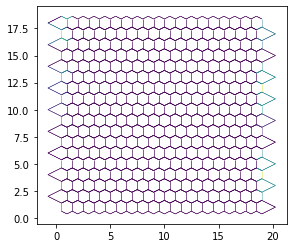

In [18]:
sheet_view(sheet_3d, edge={'color': (grad_bend**2).sum(axis=1)})



Your implementation:

```python

#grad_v = []
vert_num = len(sheet_3d.vert_df) # this is sheet_3d.Nv
grad_bend = [0]*vert_num # Better initialize as np.zeros(vert_num)

vert_coords=(sheet_3d.vert_df[coords]).values

for index, face in sheet_3d.face_df.iterrows():
    
    Ax=sheet_3d.face_df.at[index, 's_area_x'] 
    # Note that since you are already itterating over face_df,
    # you can access Ax as face['s_area_x']
    
    Ay=sheet_3d.face_df.at[index, 's_area_y']
    Az=sheet_3d.face_df.at[index, 's_area_z']
    A_dyad_A = np.array([[Ax*Ax,Ax*Ay,Ax*Az],[Ay*Ax,Ay*Ay,Ay*Az],[Az*Ax,Az*Ay,Az*Az]])
    
    A_2 = (1 / (sheet_3d.face_df.at[index, 's_area_norm']))**2
    A_1 = (1 / (sheet_3d.face_df.at[index, 's_area_norm']))
    
    AA = (np.identity(3) - ( (A_dyad_A) * A_2 ) )
    
    neighbors = sheet_3d.get_neighborhood(24,1)['face'].tolist()

    neighbors = [int(x) for x in neighbors if ~np.isnan(x)]

    sum_N_x = 0
    sum_N_y = 0
    sum_N_z = 0

    for j in neighbors:
       # print(sheet_3d.face_df.at[j, 's_area_z'])
    
        sum_N_x += sheet_3d.face_df.at[j, 's_area_x']
        sum_N_y += sheet_3d.face_df.at[j, 's_area_y']
        sum_N_z += sheet_3d.face_df.at[j, 's_area_z']
        
        neighbor_N = np.array([sum_N_x,sum_N_y,sum_N_z])
    
    vertices = objects.ordered_vert_idxs(grouped.get_group(index))
    
    n=0
    grad_v=[0,0,0]
    for i in vertices:
        
        prev = vertices[n-1] 
        nex = vertices[(n+1)%len(vertices)]
        curr = vertices[n]
        
        #print(vertices[n-1]),print(vertices[(n+1)%len(vertices)])
        dAxx=0 
        dAyy=0 
        dAzz=0

        dAxy = vert_coords[nex,2]-vert_coords[prev,2]
        dAyz = vert_coords[nex,0]-vert_coords[prev,0]
        dAzx = vert_coords[nex,1]-vert_coords[prev,1]
        dAyx = -dAxy
        dAzy = -dAyz
        dAxz = -dAzx

        dA = np.array([[dAxx,dAxy,dAxx],[dAyx,dAyy,dAyz],[dAzx,dAzy,dAzz]])
        
        AdA = np.matmul(AA,dA)
        
        grad = -(np.matmul(AdA,neighbor_N))*A_1
        
        n += 1
        
        grad_bend[curr] = grad_bend[curr] + grad
        
grad_bend
```
